# Neural Network / Multi-layer Perceptron (MLP) Regressor

In [21]:
import kagglehub

import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.inspection  import permutation_importance

In [3]:
path = kagglehub.dataset_download("budincsevity/szeged-weather")
file_name = "weatherHistory.csv"
df = pd.read_csv(path + "\\" + file_name)

# view
print(df.shape)
display(df.head())
display(df.describe())

# drop columns
df = df.drop(columns=["Formatted Date", "Daily Summary", "Loud Cover", "Apparent Temperature (C)"])

# rename columns
df.columns = ['Summary', 'PrecipType', 'Temp', 'Humidity', 'WindSpeed', 'WindBearing', 'Visibility', 'Pressure']

# convert summary to dummy
mlb = MultiLabelBinarizer()
SummarySplit = df["Summary"].str.lower().str.split(' and ')
dummies_summary = pd.DataFrame(mlb.fit_transform(SummarySplit), columns=mlb.classes_, index=df.index).iloc[:,1:].reset_index(drop=True)
df = df.drop(columns=["Summary"])

# convert precip type to dummy 
dummies_precip_type = pd.get_dummies(df["PrecipType"], drop_first=True).astype(int).reset_index(drop=True)
df = df.drop(columns=["PrecipType"])

# join to full dataframe
df = pd.concat([df, dummies_summary, dummies_precip_type], axis=1)
df

(96453, 12)


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


,Temp,Humidity,WindSpeed,WindBearing,Visibility,Pressure,clear,dangerously windy,drizzle,dry,foggy,humid,light rain,mostly cloudy,overcast,partly cloudy,rain,windy,snow
0,9.472222,0.89,14.1197,251.0,15.8263,1015.13,0,0,0,0,0,0,0,0,0,1,0,0,0
1,9.355556,0.86,14.2646,259.0,15.8263,1015.63,0,0,0,0,0,0,0,0,0,1,0,0,0
2,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0,0,0,0,0,0,0,1,0,0,0,0,0
3,8.288889,0.83,14.1036,269.0,15.8263,1016.41,0,0,0,0,0,0,0,0,0,1,0,0,0
4,8.755556,0.83,11.0446,259.0,15.8263,1016.51,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96448,26.016667,0.43,10.9963,31.0,16.1000,1014.36,0,0,0,0,0,0,0,0,0,1,0,0,0
96449,24.583333,0.48,10.0947,20.0,15.5526,1015.16,0,0,0,0,0,0,0,0,0,1,0,0,0
96450,22.038889,0.56,8.9838,30.0,16.1000,1015.66,0,0,0,0,0,0,0,0,0,1,0,0,0
96451,21.522222,0.60,10.5294,20.0,16.1000,1015.95,0,0,0,0,0,0,0,0,0,1,0,0,0


In [4]:
# split datasets in y (response) and X (predictors) 
# for train, test, and validation sets

response = "Temp"

y = df[[response]]
X = df.drop(columns=[response])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [5]:
mlp = MLPRegressor(random_state=42)

params = {
    "hidden_layer_sizes": [(50,), (100,), (100, 50)],
    "activation": ['relu', 'tanh'],
    "solver": ['adam', 'lbfgs'],
    "alpha": [0.0001, 0.001],
    "learning_rate": ['constant', 'adaptive']
}

grid_search = GridSearchCV(
    estimator = mlp,
    param_grid = params,
    cv = 3,
    scoring = "r2",
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Best Score: 0.6482970861216791


In [6]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print("RMSE:", root_mean_squared_error(y_val, y_pred))
print("R2:", r2_score(y_val, y_pred))

RMSE: 5.711286220397765
R2: 0.6393993782582121


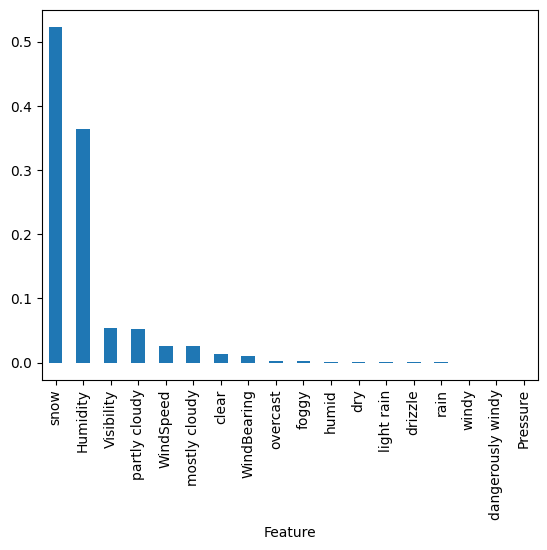

In [27]:
result = permutation_importance(best_model, X_val, y_val, n_repeats=30, random_state=42, scoring="r2")
df_result = pd.DataFrame()
df_result["Feature"] = X_val.columns
df_result["Importance"] = result.importances_mean
df_result = df_result.sort_values(by="Importance", ascending=False)
df_result.plot(kind="bar", x="Feature", y="Importance", legend=False)
plt.show() 

In [22]:
#normalise data so it's all on the same scale
scaler = StandardScaler()

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train.iloc[:,1:]), columns=X_train.columns[1:])
y_train_norm = scaler.fit_transform(y_train)

X_test_norm = pd.DataFrame(scaler.fit_transform(X_test.iloc[:,1:]), columns=X_test.columns[1:])
y_test_norm = scaler.fit_transform(y_test)

X_val_norm = pd.DataFrame(scaler.fit_transform(X_val.iloc[:,1:]), columns=X_val.columns[1:])
y_val_norm = scaler.fit_transform(y_val)

In [ ]:
mlp2 = MLPRegressor(random_state=42)

params = {
    "hidden_layer_sizes": [(100, 100), (100, 100, 100), (100, 100, 100, 100)],
    "activation": ['relu', 'tanh'],
    "solver": ['adam', 'sgd'],
    "alpha": [0.0001, 0.001],
    "learning_rate": ['constant', 'adaptive']
}

grid_search = GridSearchCV(
    estimator = mlp2,
    param_grid = params,
    cv = 3,
    scoring = "r2",
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(X_train_norm, y_train_norm)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Best Score: 0.6132902062576949


In [28]:
best_model2 = grid_search.best_estimator_
y_pred = best_model2.predict(X_val_norm)
print("RMSE:", root_mean_squared_error(y_val_norm, y_pred))
print("R2:", r2_score(y_val_norm, y_pred))

RMSE: 0.6193038915818896
R2: 0.6164626898715271


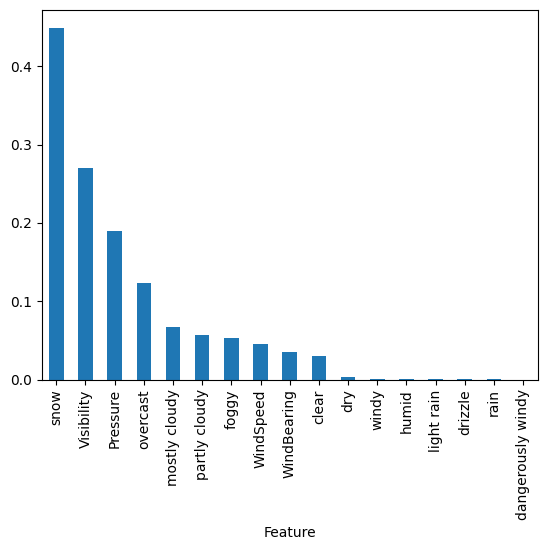

In [ ]:
result = permutation_importance(best_model2, X_val_norm, y_val_norm, n_repeats=30, random_state=42, scoring="r2")
df_result = pd.DataFrame()
df_result["Feature"] = X_val_norm.columns
df_result["Importance"] = result.importances_mean
df_result = df_result.sort_values(by="Importance", ascending=False)
df_result.plot(kind="bar", x="Feature", y="Importance", legend=False)
plt.show()